#  PRESENTATION de Projet : Problème de ML sur des données réelles d'Open Food Fact

#### SOMMAIRE

####   1  Description de projet

####   2  MISE EN PLACE DE L'ENVIRONNEMENT PYTHON

####   3  ANALYSE UNIVARIEE: traitement sur le retour de nootebook "data_cleaning"

####   4  ANALYSES MULTIVARIEES

#####       a)    ANALYSE PAR COMPOSANTES PRINCIPALES : ACP

#####       b)    ANALYSE PAR CLUSTERING HIEARCHIQUE PAR COMPOSANTES PRINCIPALES : HCPC

#####       C)    ANALYSE PAR CLUSTERING PAR K-MEANS

####   5  CONCLUSIONS ET INCORPORATIONS DES RESULTATS A EQUILIBRE.

##  Mise en place de l'environnement python et fonction usuelles

 ### Description de projet

Le projet a pour objectif de répondre à un enjeu majeur de la communauté Open Food Fact en proposant des méthodes de clustering plus performantes pour améliorer la catégorisation des produits. 

Nous devons mettre en place un workflow avec du code et des analyses pour répondre à ce besoin.  

Pour répondre à ce défi, nous avons sélectionné et développé un ensemble de tâches préalablement définies par nos pairs. Notre approche se concentre sur l'optimisation de la catégorisation des produits à travers une méthode de clustering plus fine que celle qui est actuellement en place. 

Plus précisément, nous avons choisi de classer les produits selon leur Nutri-Score. En utilisant cette méthode de classification, nous espérons offrir une catégorisation plus pertinente et plus précise des produits alimentaires pour aider les utilisateurs d'Open Food Fact à mieux comprendre les informations nutritionnelles des produits qu'ils consomment.

In [ ]:
%matplotlib notebook
%matplotlib
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_cs

# scipy clusturing
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram 

# data preprocessing
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# data visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection


# Definition des fonctions usuelles

In [2]:
def nb_lines(data):     
    ''' returns number of rows'''
    return len(data)

def nb_columns(data):
    ''' returns number of columns'''
    return len(data.columns)

def missing_cells(data):
    ''' returns number of missing cells'''
    return data.isna().sum().sum()

def missing_cells_percent(data):
    ''' returns percentage of missing cells'''
    return data.isna().sum().sum()/(data.size)

def count_duplicates_rows(data):
    ''' returns number of duplicate rows'''
    return len(data)-len(data.drop_duplicates())

def count_duplicates_rows_percent(data):
    '''  returns percentage of duplicate rows'''
    return count_duplicates_rows(data)/nb_lines(data)
def data_set_overview(data):    
    '''  prints a dataframe summary containing:number of rows, columns,
         missing cells and duplicate rows'''
   
    print('**********************************************************************')
    print('Data : {}'.format(namestr(data, globals())))
    print('Number of variables : {}'.format(nb_columns(data)))
    print('Number of observations : {}'.format(nb_lines(data)))
    print('Missing cells : {}'.format(missing_cells(data)))
    print('Missing cells in % : {:.2%}'.format(missing_cells_percent(data)))
    print('Duplicate rows : {}'.format(count_duplicates_rows(data)))
    print('Duplicate rows in % : {:.2%}'.format(count_duplicates_rows_percent(data)))
    return None

def dataset_variables_overview(data):
    '''  returns a summary containing : variable name, type, distinct values, 
           missing values, and numerical  statistics for numerical variables '''
    print('************************************************************************')
    print('Data : {}'.format(namestr(data, globals())))
    print('************************************************************************')
    df = pd.DataFrame(columns=['Variable name','Variable type','Distinct','% distinct',
                               'Missing','% missing', 'Mean', 'Median', 'Skew', 
                               'Kurtosis', 'Variance', 'Stdev', 'min','25%','50%',
                               '75%','max'])
    for column in data.columns:
        var_type = data[column].dtypes
        distinct = len(data[column].unique())
        percent_distinct = len(data[column].unique())/len(data[column])
        missing = missing_cells(data[column])
        percent_missing = missing_cells_percent(data[column])
        if var_type != 'object':    
             df = df.append(pd.DataFrame([[column,var_type,distinct,percent_distinct,missing,
                                           percent_missing,
                                           data[column].mean(),data[column].median(),
                                           data[column].skew(),
                                           data[column].kurtosis(),data[column].var(ddof=0),
                                           data[column].std(ddof=0),data[column].min(),
                                           data[column].quantile(0.25),
                                           data[column].quantile(0.5),data[column].quantile(0.75),
                                           data[column].max()]], 
                                          columns=['Variable name','Variable type','Distinct',
                                                   '% distinct','Missing',
                                                   '% missing', 'Mean', 'Median', 'Skew', 
                                                   'Kurtosis','Variance', 'Stdev',
                                                   'min','25%','50%','75%','max']))
        else:            
            df = df.append(pd.DataFrame([[column,var_type,distinct,percent_distinct,missing,
                                          percent_missing,
                                          '','','','','','','','','','','']], 
                                        columns=['Variable name','Variable type',
                                                 'Distinct','% distinct', 'Missing','% missing',
                                                 'Mean', 'Median','Skew', 'Kurtosis', 'Variance',
                                                 'Stdev', 'min','25%','50%','75%','max']))
    return df
            
def output_dataset_variables_overview(data):
    '''output to csv files the variables overview '''
    summary = dataset_variables_overview(data)
    summary.to_csv('output_dataset_variables_overview.csv',sep=',', index = False)
    
def dataset_columns(data):
    ''' prints variables in dataframe'''
    print('**********************************************************************')
    print('Data : {}'.format(namestr(data, globals())))
    print('Columns : {}'.format(data.columns.values))

def namestr(obj, namespace):
    '''  returns variable name in namespace '''
    return [name for name in namespace if namespace[name] is obj]

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc 
                              #   les 6 premières composantes
        if d2 < n_comp:
           # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))
           # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), 
                max(pcs[d2,:])
            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', 
                                 rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
           # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.savefig('Dendrogram.png')
    plt.show()
    
def columns_type(data): 
    '''  returns a dataframe with data's variable names and types '''
    df = pd.DataFrame(data.dtypes)[0]
    summary = pd.DataFrame(columns=['Variable name', 'Variable type'])
    summary['Variable name']=data.columns
    summary['Variable type']=list(df)
    return summary

## Import des données nettoyées du premier notebook

In [3]:
# Import des données nettoyées

gamma = pd.read_csv('../input/data_cleaned.csv',
                    sep=',', error_bad_lines=False, low_memory=False)

gamma.head(6)

product_name           code  \
0                 Farine de blé noir  0000000003087   
1                            Peanuts  0000000004559   
2             Organic Salted Nut Mix  0000000016087   
3                    Organic Polenta  0000000016094   
4  Breadshop Honey Gone Nuts Granola  0000000016100   
5      Organic Long Grain White Rice  0000000016117   

                                                 url  \
0  http://world-en.openfoodfacts.org/product/0000...   
1  http://world-en.openfoodfacts.org/product/0000...   
2  http://world-en.openfoodfacts.org/product/0000...   
3  http://world-en.openfoodfacts.org/product/0000...   
4  http://world-en.openfoodfacts.org/product/0000...   
5  http://world-en.openfoodfacts.org/product/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
3             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   
4             usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
5             usda-ndb-import  1489055730  2017-03-09T10:35:30Z   

  last_modified_t last_modified_datetime  \
0      1474103893   2016-09-17T09:18:13Z   
1      1489069957   2017-03-09T14:32:37Z   
2      1489055731   2017-03-09T10:35:31Z   
3      1489055653   2017-03-09T10:34:13Z   
4      1489055651   2017-03-09T10:34:11Z   
5      1489055730   2017-03-09T10:35:30Z   

                                        generic_name quantity  ... fiber_100g  \
0  Pâtes alimentaires au blé dur de qualité supér...      1kg  ...        0.0   
1                                                  0        0  ...        7.1   
2                                                  0        0  ...        7.1   
3                                                  0        0  ...        5.7   
4                                                  0        0  ...        7.7   
5                                                  0        0  ...        0.0   

  proteins_100g salt_100g sodium_100g vitamin-a_100g vitamin-c_100g  \
0          0.00   0.00000       0.000            0.0         0.0000   
1         17.86   0.63500       0.250            0.0         0.0000   
2         17.86   1.22428       0.482            0.0         0.0000   
3          8.57   0.00000       0.000            0.0         0.0000   
4         13.46   0.00000       0.000            0.0         0.0000   
5          8.89   0.00000       0.000            0.0         0.0027   

  calcium_100g iron_100g nutrition-score-fr_100g nutrition-score-uk_100g  
0        0.000   0.00000                     0.0                     0.0  
1        0.071   0.00129                     0.0                     0.0  
2        0.143   0.00514                    12.0                    12.0  
3        0.000   0.00000                     0.0                     0.0  
4        0.038   0.00346                     0.0                     0.0  
5        0.044   0.00000                     0.0                     0.0  

[6 rows x 63 columns]

In [4]:
gamma = gamma.fillna(0)

In [5]:
gamma.set_index('product_name',inplace = True)

In [6]:
gamma = gamma.replace('$','')

In [7]:
data_set_overview(gamma)

**********************************************************************
Data : ['gamma']
Number of variables : 62
Number of observations : 284137
Missing cells : 0
Missing cells in % : 0.00%
Duplicate rows : 0
Duplicate rows in % : 0.00%


## Analyse univariée
#### Rappel de l'analyse univariée du notebook n°1 , les variables quatitatives choisies ,les boites à moustaches.

In [8]:
quant_variables = ['energy_100g','fat_100g','saturated-fat_100g',
                   'sugars_100g','fiber_100g','proteins_100g',
                   'salt_100g','sodium_100g','nutrition-score-fr_100g']

variables    =    [ 'additives_n', 'ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n','energy_100g',        
                    'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
                    'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 
                    'fiber_100g','proteins_100g', 'salt_100g', 'sodium_100g', 
                    'vitamin-a_100g','vitamin-c_100g', 'calcium_100g',
                    'iron_100g','nutrition-score-fr_100g','nutrition-score-uk_100g']

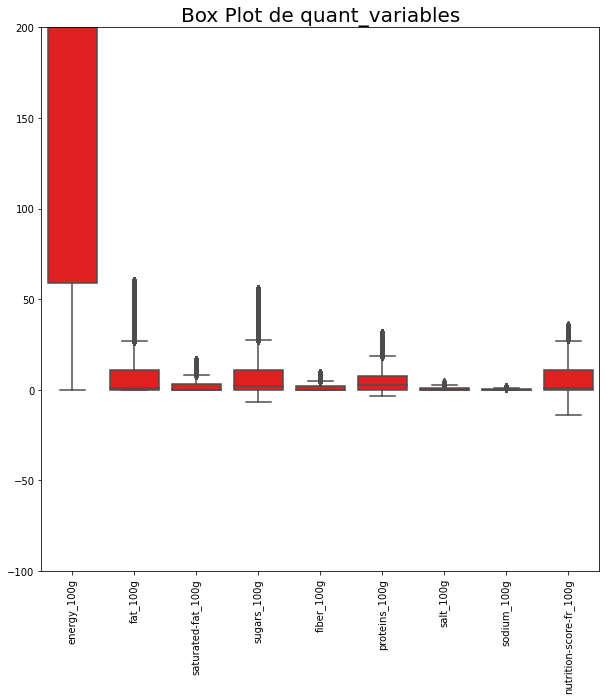

In [9]:
degrees = 90

plt.figure(figsize=(10,10)) ## Changing the Figure Size  box=sns.boxplot( data=gamma[quant_variables]) # Define the plot with variables 
ax=plt.axes()
plt.xticks(rotation = degrees)
ax.set_ylim([-1e2,2e2])
sns.boxplot(data=gamma[quant_variables],color='red').set_title("Box Plot de quant_variables",fontsize=20) # Set the Tittle for the defined plot
plt.show()

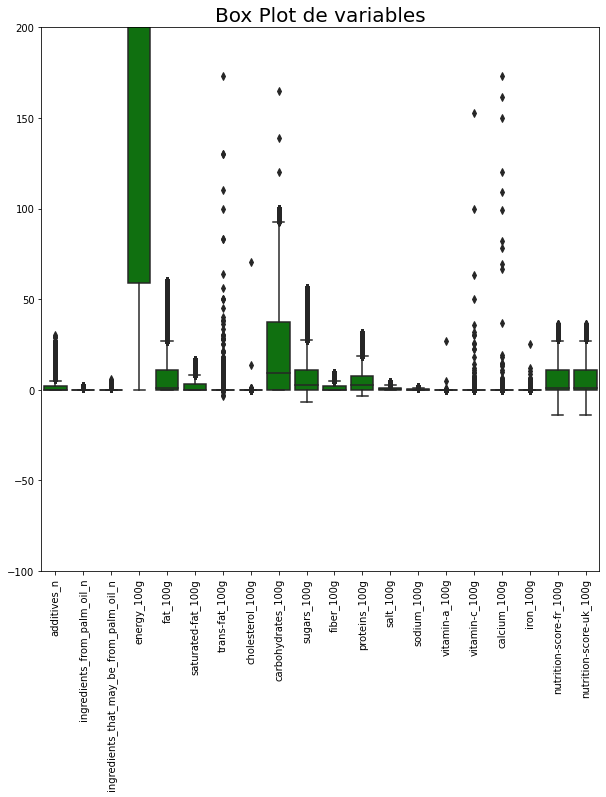

In [10]:
degrees = 90

plt.figure(figsize=(10,10)) ## Changing the Figure Size  box=sns.boxplot( data=gamma[quant_variables]) # Define the plot with variables 
ax=plt.axes()
plt.xticks(rotation = degrees)
ax.set_ylim([-1e2,2e2])
sns.boxplot(data=gamma[variables],color='green').set_title("Box Plot de variables",fontsize=20) # Set the Tittle for the defined plot
plt.show()

# Analyse multivariée

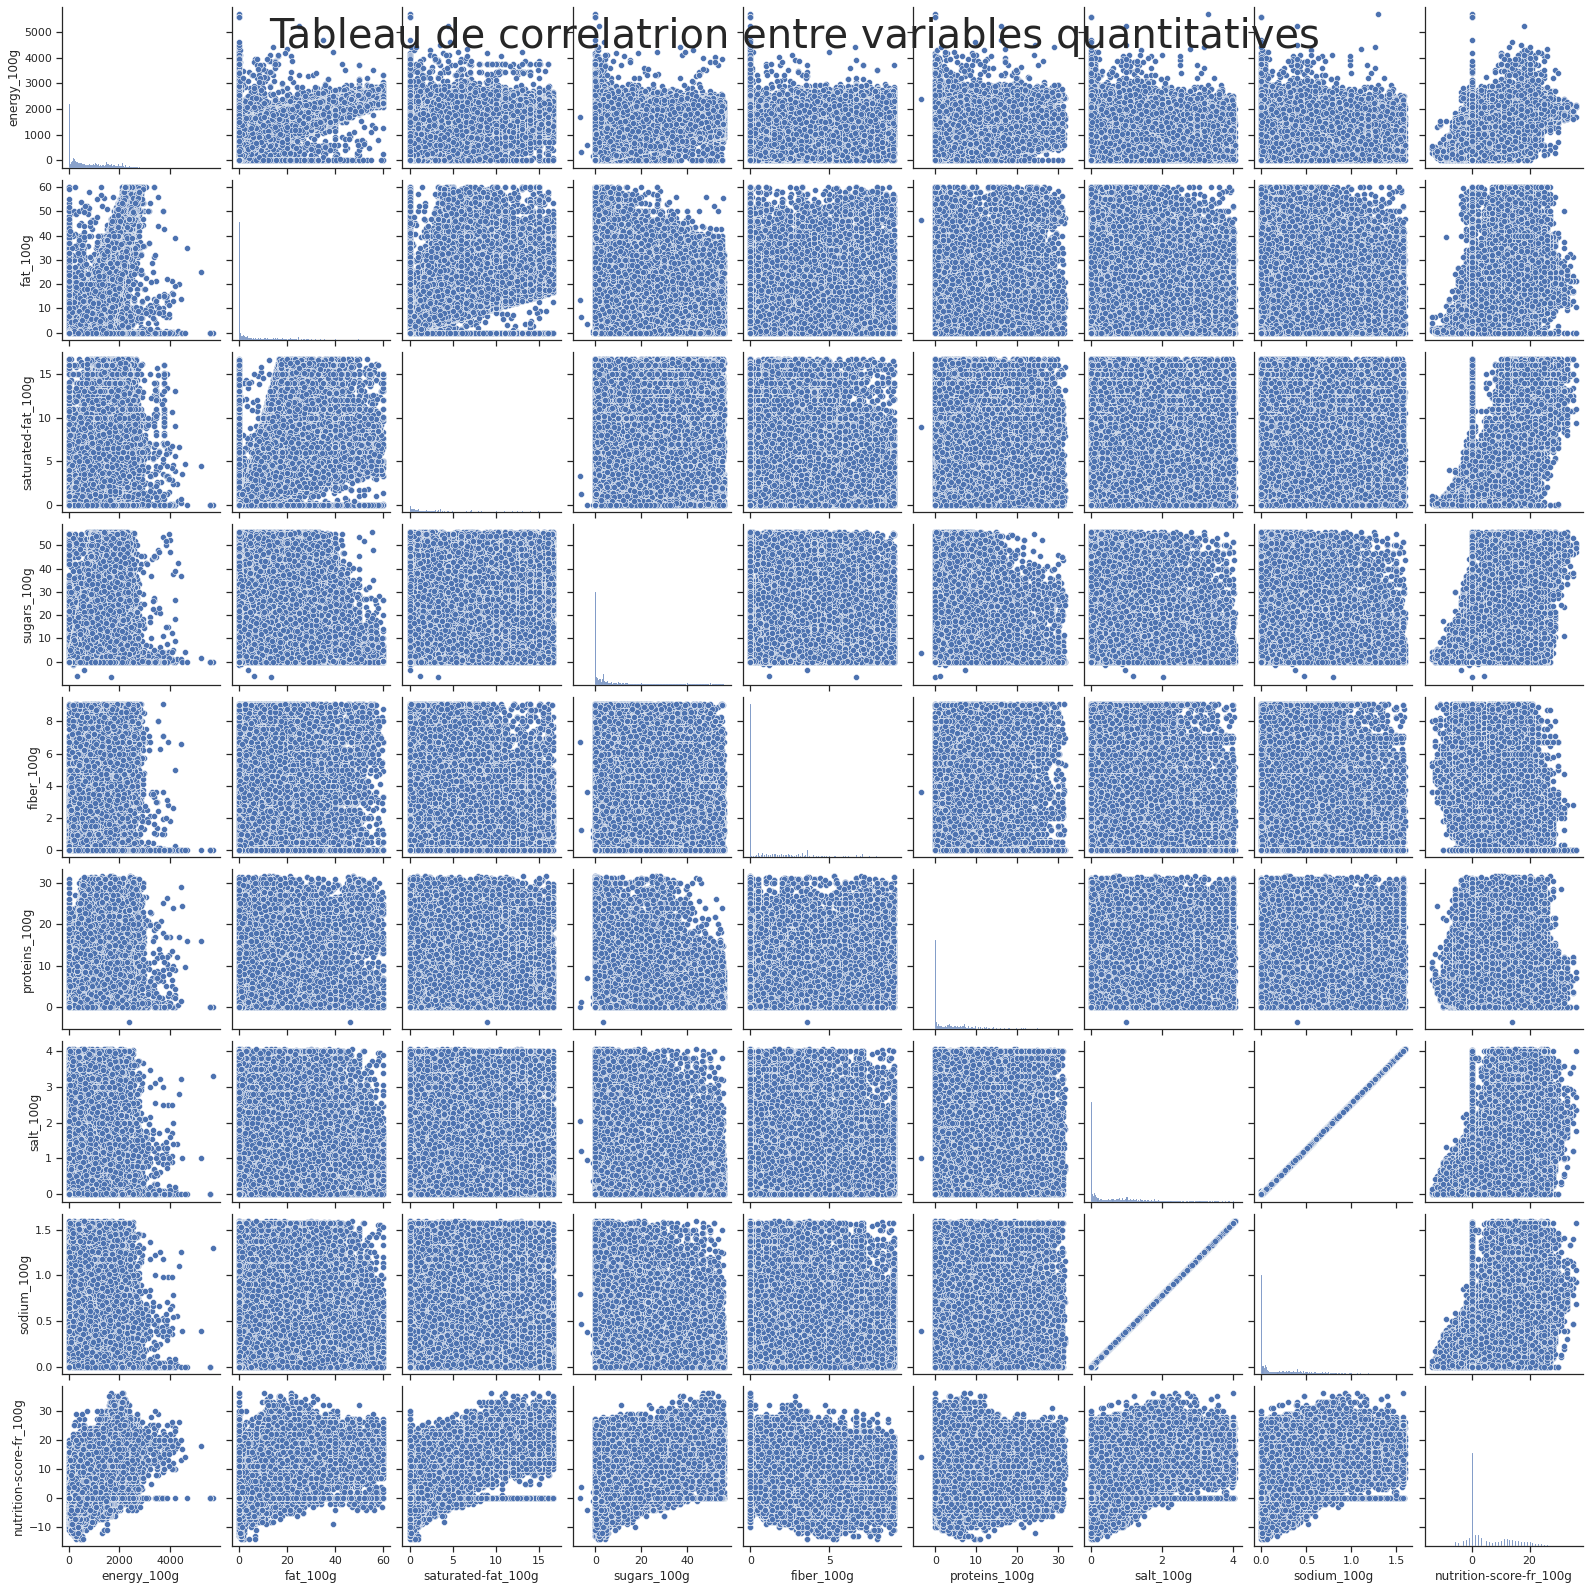

In [11]:


ax = plt.axes
sns.set(style="ticks")
sns.pairplot(gamma[quant_variables])
plt.suptitle('Tableau de correlatrion entre variables quantitatives',fontsize = 40)
plt.show()

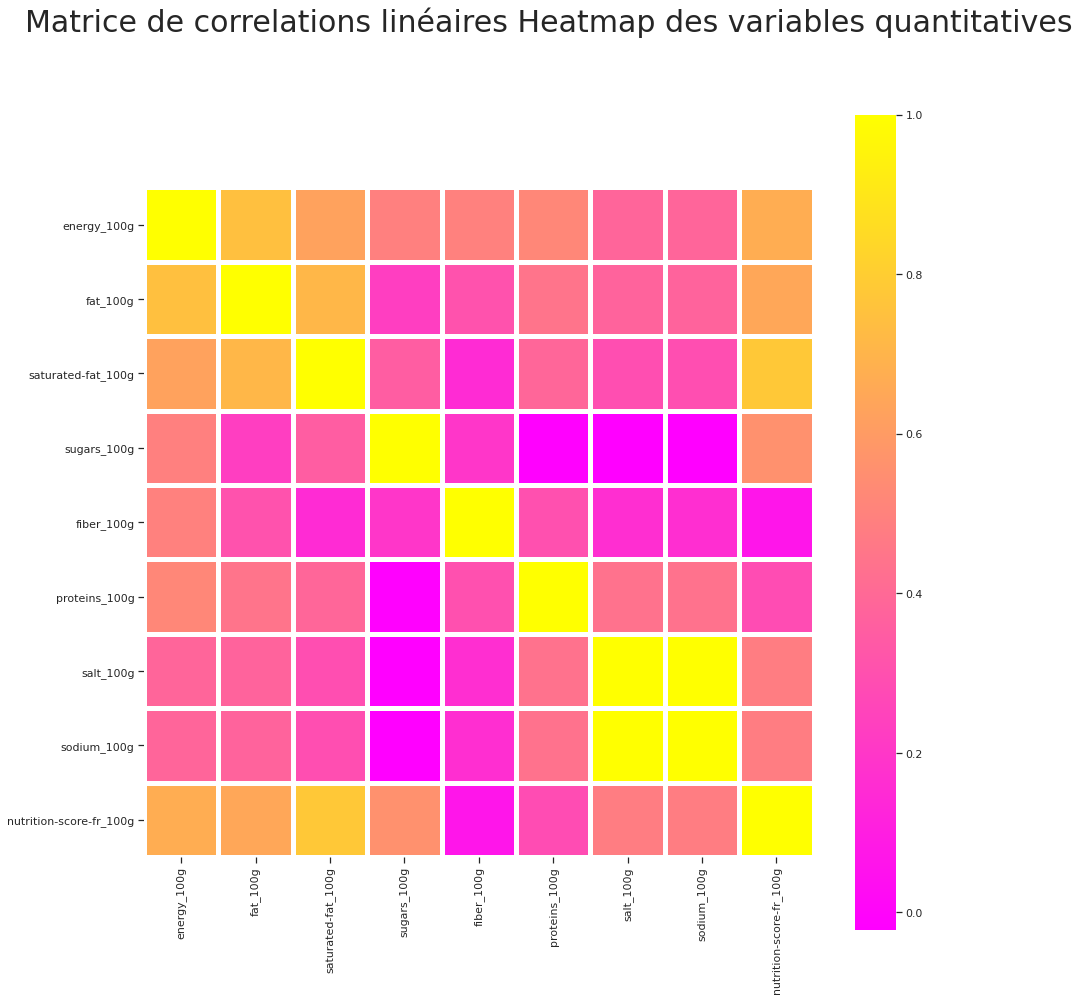

In [12]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(gamma[quant_variables].corr(),annot = False,square=True,linewidth = 5,cmap ="spring")
plt.suptitle('Matrice de correlations linéaires Heatmap des variables quantitatives',fontsize = 30)
plt.show()

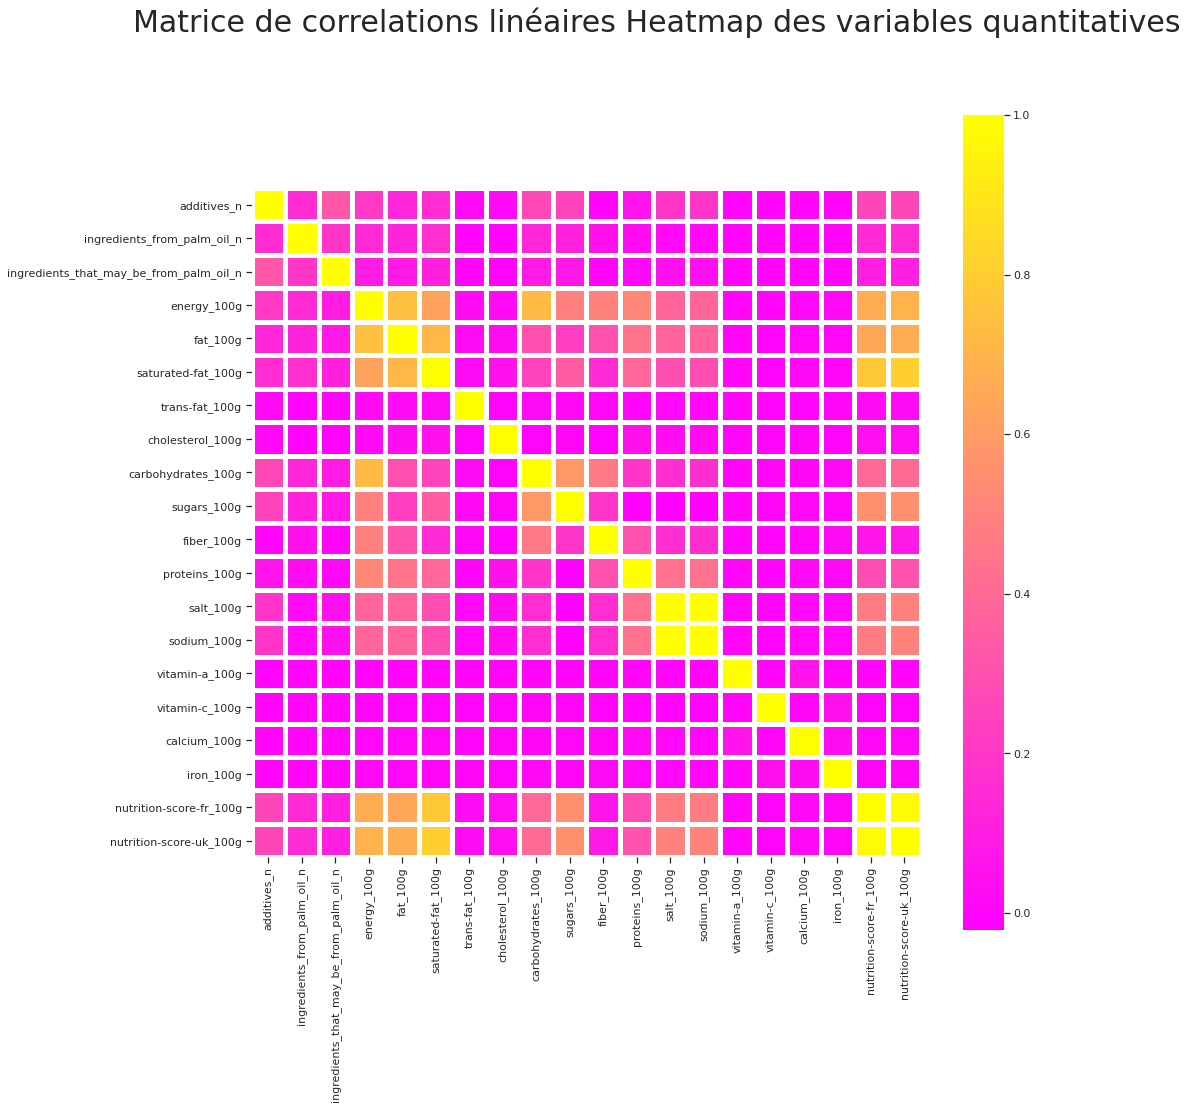

In [13]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(gamma[variables].corr(),annot = False,square=True,linewidth = 5,cmap ="spring")
plt.suptitle('Matrice de correlations linéaires Heatmap des variables quantitatives',fontsize = 30)
plt.show()

### Nous remarquons quelques  corrélations linéaires quasi parfaite entre sodium et salt, et un semblant de relation  entre les variables energy_100g et nutrition-score-fr_100g.

### Nous remarquons aussi la présence de corrélations entre les variables ( exemple : fat_100g vs satured-fat_100G entre autres ). Ceci suggère donc la nécessité d'une analyse par composantes principales afin de projetter notre dataset sur les bons axes.

# Analyse par composantes principales : ACP

In [14]:
gamma.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'generic_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_en', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en',
       'purchase_places', 'stores', 'countries', 'countries_tags',
       'countries_en', 'ingredients_text', 'allergens', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en',
       'main_category', 'main_category_en', 'image_url', 'image_small_url',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'pro

In [15]:
variables = [ 'additives_n', 'ingredients_from_palm_oil_n',
              'ingredients_that_may_be_from_palm_oil_n',
              'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
              'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
              'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g',
              'vitamin-c_100g', 'calcium_100g', 'iron_100g',
              'nutrition-score-fr_100g']

In [16]:
# ACP pour le dataset gamma
# Separation des variables

gamma.replace([np.inf, -np.inf], 0, inplace=True)
x = gamma[variables].values

# Separation de la variable cible
y = gamma['nutrition-score-fr_100g'].values
hue = pd.DataFrame(y)

scaler = StandardScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)
X_scaled = np.nan_to_num(X_scaled, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

pca = PCA(n_components=12)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

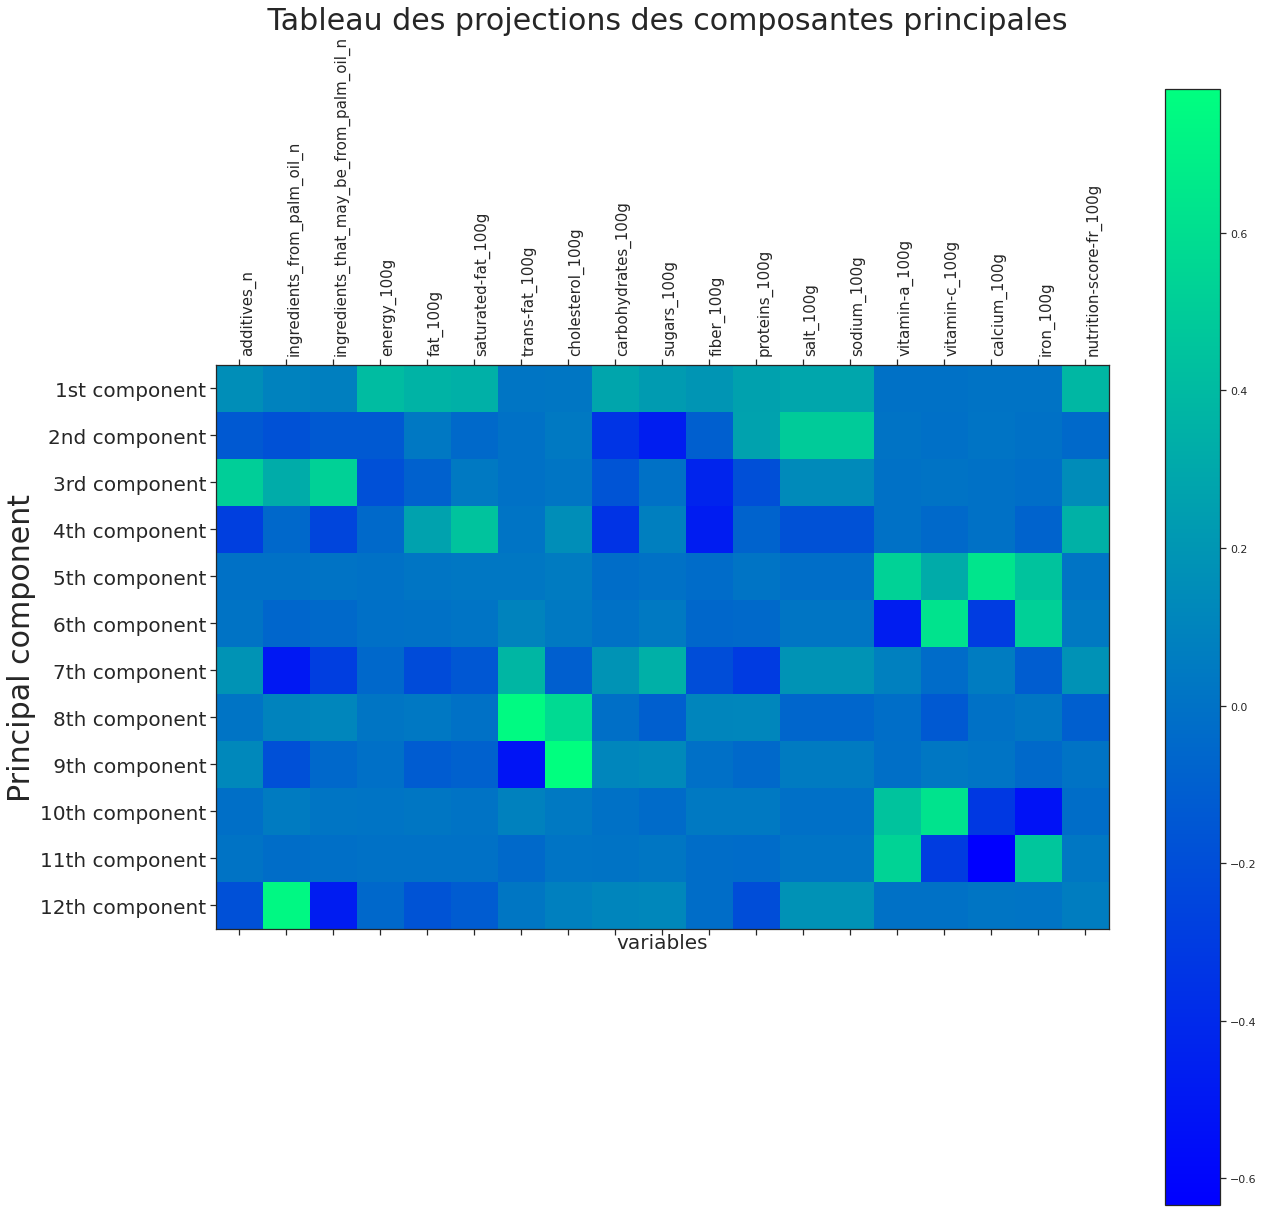

In [17]:
plt.figure(figsize = (20,20))
plt.matshow(pca.components_,fignum = 1 ,cmap=('winter'));
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11], ['1st component', '2nd component','3rd component','4th component', '5th component',
                                       '6th component','7th component','8th component',' 9th component', '10th component',
                                       '11th component','12th component'],fontsize = 20);                                   
plt.colorbar();
plt.xticks(range(len(variables)),variables, rotation = 90, fontsize=15, ha = 'left');
plt.xlabel('variables',fontsize = 20);
plt.ylabel('Principal component',fontsize = 30);
plt.title(' Tableau des projections des composantes principales',fontsize =30)
plt.show()

La première composante caractérise les produits ayant des projections positives sur 'energy_100g' et 'nutrition-score-fr_100g', mais aussi porté par les variables ( saturated-fat_100g,fat,carbohydrates , sugars et proteins ). Cet axe permet donc de selectionner des ingrédients destinés à un régime générique de perte de poids et d'amelioration de la qualité de la nutrition.

La deuxieme composante caractérise principalement les produits riche en sel et sodium.(A deconseiller).


La troisieme composante caractérise les produits riche en huile de palme et additifs (a eviter).


La quatriéme composante caractérise les produits riche en  fat et satured fat.ils sont énergitiques et bon nutriscore.(Trés faibles en huile de palme et additifs).

La cinquiéme compsante est celle des produits riche en vitamine A et C ainsi que le fer et le calcium.

La sixiéme composante est celle des produits riche seulement en vitamine c et en fer avec un bon  nutriscore .

la huitiéme composante met en evidence l'effet negatif du fat et cholesterol.

### Bien sur j'ai choisi ce nombre de composantes apres plusieurs choix et calcul de l'explained variance et 12 composantes est le nombre qui nous donne une variance à 90% .

In [18]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


fig =px.bar( x=range(1, exp_var_cumul.shape[0] + 1),
         y=exp_var_cumul,
         labels={"x": "# Components", "y": "Explained Variance"} )

fig.show()

In [19]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area( x=range(1, exp_var_cumul.shape[0] + 1),
         y=exp_var_cumul,
         labels={"x": "# Components", "y": "Explained Variance"} )
fig.show()

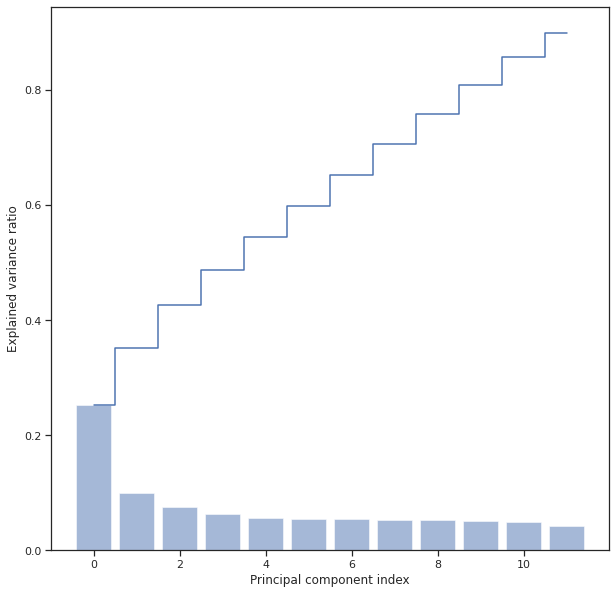

In [20]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
fig = plt.figure(figsize=(10,10))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.show()


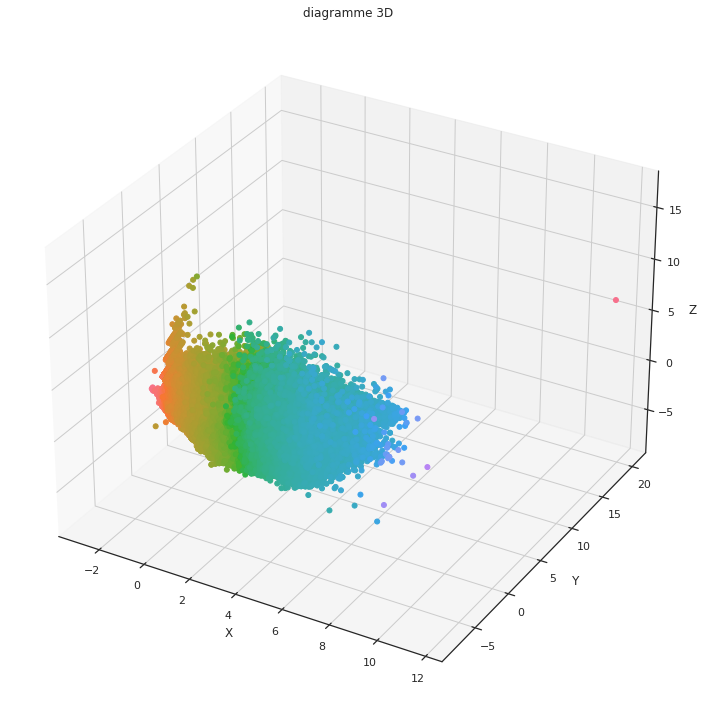

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
%matplotlib inline

# Tracé du résultat en 3D
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection='3d') # Affichage en 3D

# Construction des histogrammes et affichage barre par barre
x = X_pca[:,0]
y = X_pca[:,1]
z = X_pca[:,2]

# On peut définir une couleur différente pour chaque barre
# Ici la première barre est en cyan.
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=25, c=x, marker='o', cmap=cmap, alpha=1)  # Ajout d'une barre

plt.title("diagramme 3D")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

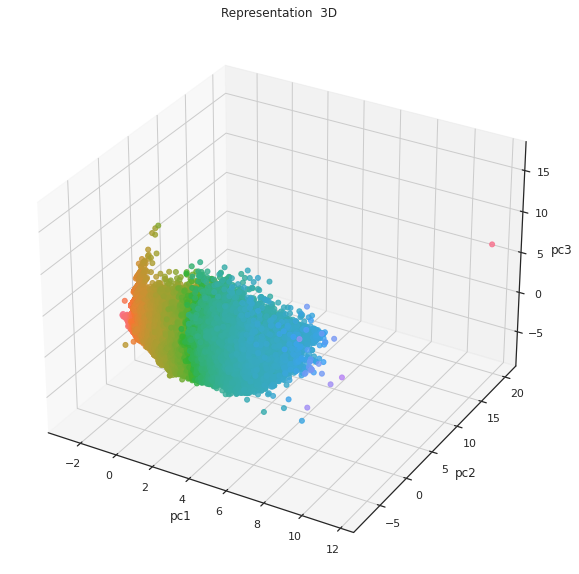

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
x = X_pca[:,0]
y = X_pca[:,1]
z = X_pca[:,2]
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=25, c=x, marker='o', cmap =cmap, alpha=0.8)  # Tacé 3D
plt.title("Representation  3D")
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.legend
plt.show()

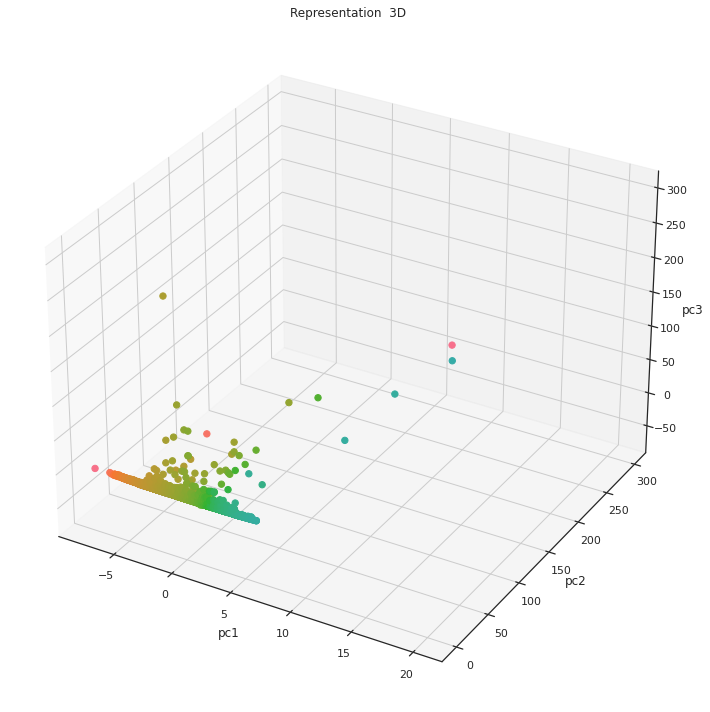

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  # Fonction pour la 3D
x = X_pca[:,1]
y = X_pca[:,4]
z = X_pca[:,7]

plt.rcParams["figure.autolayout"] = True
# Tracé du résultat en 3D
fig = plt.figure(figsize=(15,10))
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)  # Tacé 3D
plt.title("Representation  3D")
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.legend
plt.show()

   # HCPC

## Maintenant effectuons un clustering hierarchique par composantes principales :

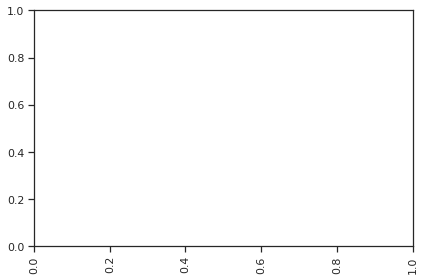

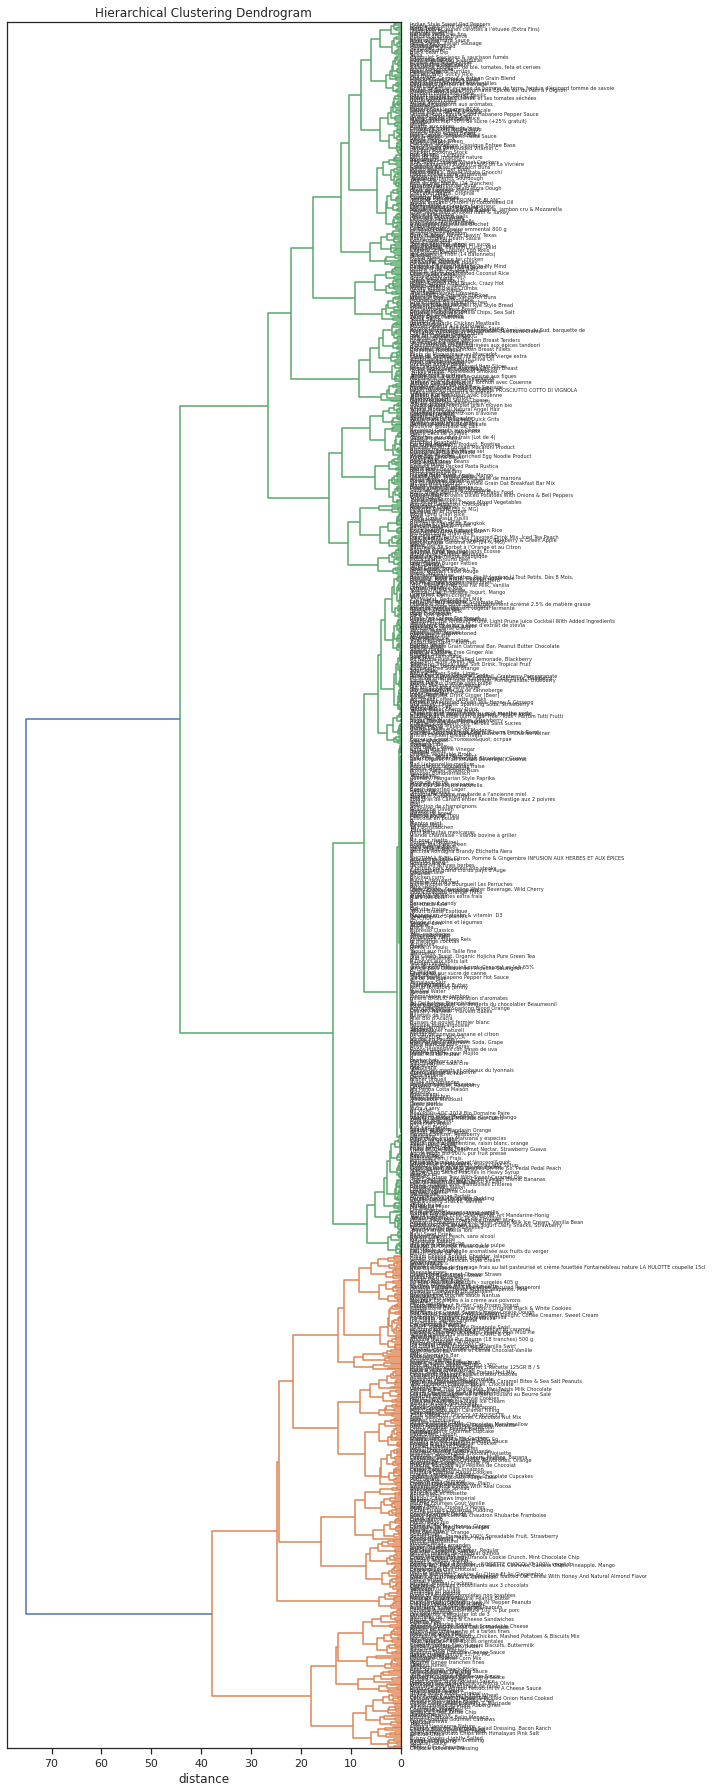

In [24]:

# Force the figure to be drawn

sample = gamma[quant_variables].sample(n = 1000)

# préparation des données pour le clustering
X = sample.values
names = sample.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
degrees=90
plt.xticks(rotation=degrees)
plot_dendrogram(Z, names)
plt.show()

In [25]:
clusters = fcluster(Z,t=40,criterion='distance')

idg = np.argsort(clusters)

#affichage des observations et leurs groupes
clusters = pd.DataFrame(sample.index[idg],clusters[idg])
clusters

product_name
1                                       Pastry Crisps
1                           Pat.petit Pot CREM.VANIL4
1                   Granny B's, Frosted Sugar Cookies
1   Noisette Décortiquée Sachet 1 Recette 125GR B / S
1                                      Balisto Apple 
..                                                ...
3                          Tofu Ail Ciboulette 2X100G
3            Chicken Cacciatore Classique Entree Base
3                                   Organic Snack Mix
3                             Original Barbecue Sauce
3                                        Charro Beans

[1000 rows x 1 columns]

In [26]:
clusters.to_csv('PCA_clusters.csv',sep=',', index = True)

## K-Means

### Dans cette partie, nous procédons à une autre méthode de clustering qui est le K-means.

In [27]:
# k-means sur les données centrées et réduites
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=6)
kmeans.fit(sample)

# index triés des groupes
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes
groups = pd.DataFrame(sample.index[idk],kmeans.labels_[idk])
groups

product_name
0                                    Red Kidney Beans
0                  Barbeque Sauce, Mustard On My Mind
0                                        Eggplant Dip
0                          Tofu Ail Ciboulette 2X100G
0                               Tomato Condensed Soup
..                                                ...
5                      Damtuh, Ice Tea, Honey, Ginger
5                        Turkey Snack Bites, Original
5   Cœur de fruits cuits au chaudron Rhubarbe Fram...
5              Canyon Bakehouse, Deli Rye Style Bread
5                                    Pizza au chorizo

[1000 rows x 1 columns]

In [28]:
groups.to_csv('Kmeans_clusters.csv',sep=',', index = True)

In [29]:
# correspondance avec les groupes de la CAH
pd.crosstab(clusters.index,kmeans.labels_)

col_0   0   1    2   3   4   5
row_0                         
1      56  34  109  36   7  44
2      67  40  153  54  19  61
3      78  29  110  48   6  49

### La matrice n'est pas diagonale et les clusters ne sont pas homogénes,ce qui nous améne à exploiter notre PCA et le clustering, hiearchique HCPC.

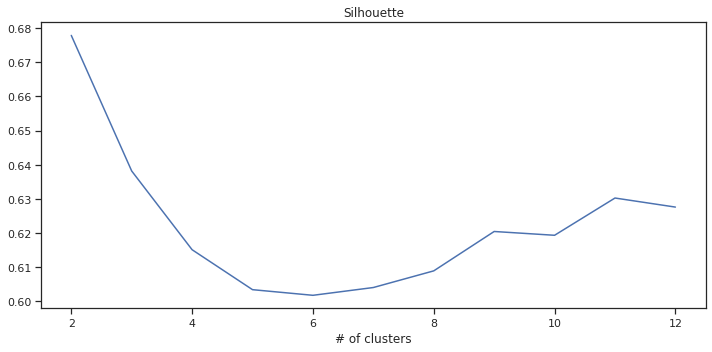

In [30]:
# librairie pour évaluation des partitions
from sklearn import metrics

# utilisation de la métrique "silhouette"
# faire varier le nombre de clusters de 2 à 12
res = np.arange(11,dtype="double")
for k in np.arange(11):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(sample)
    res[k] = metrics.silhouette_score(sample,km.labels_)
    #print(res)
    
#graphique
fig = plt.figure(figsize=(10,5))
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,13,1),res)
plt.show()

il semble d'après le graphique précédent que le nombre optimal de clusters se situe autour de 6.


L’idée est de comparer les moyennes des variables actives conditionnellement aux groupes. Il est possible de quantifier globalement l’amplitude des écarts avec la proportion de variance expliquée (carré du rapport de corrélation). La démarche peut être étendue aux variables illustratives. Pour les catégorielles, nous confronterions les distributions conditionnelles. L’approche est simple et les résultats faciles à lire. Rappelons cependant que nous ne tenons pas compte des liaisons entre les variables dans ce cas .

In [31]:
#moyenne par variable
m = sample.mean()

#TSS
TSS = sample.shape[0]*sample.var(ddof=0)
print(TSS)

energy_100g                5.510913e+08
fat_100g                   1.189786e+05
saturated-fat_100g         1.412530e+04
sugars_100g                1.591204e+05
fiber_100g                 4.344838e+03
proteins_100g              4.027121e+04
salt_100g                  5.860488e+02
sodium_100g                9.083692e+01
nutrition-score-fr_100g    5.945444e+04
dtype: float64


In [32]:
#data.frame conditionnellement aux groupes
gb = sample.groupby(kmeans.labels_)

#effectifs conditionnels
nk = gb.size()
print(nk)

0    201
1    103
2    372
3    138
4     32
5    154
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

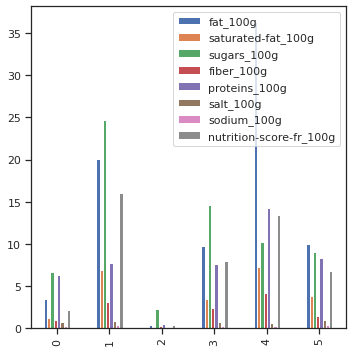

In [33]:
#moyennes conditionnelles
mk = gb.mean()

# print(mk)
mk_no_energy = mk.drop("energy_100g",axis=1)
mk.plot.bar(y=mk_no_energy.columns,figsize=(5,5))
plt.show

<AxesSubplot:>

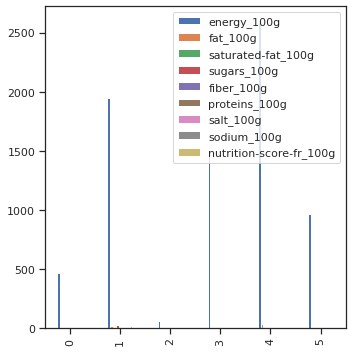

In [34]:
# print(mk)
mk.plot.bar(y=mk.columns,figsize=(5,5))

In [35]:
#pour chaque groupe écart à la moyenne par variable
EMk = (mk-m)**2

#pondéré par les effectifs du groupe
EM = EMk.multiply(nk,axis=0)

#somme des valeurs => BSS
BSS = np.sum(EM,axis=0)
BSS

energy_100g                5.326522e+08
fat_100g                   6.667174e+04
saturated-fat_100g         5.623230e+03
sugars_100g                4.745317e+04
fiber_100g                 1.163742e+03
proteins_100g              1.409323e+04
salt_100g                  1.212097e+02
sodium_100g                1.878751e+01
nutrition-score-fr_100g    2.601306e+04
dtype: float64

In [36]:
BSS_ap = BSS[1:]
BSS_ap = BSS_ap.reset_index(name = 'value')
BSS_ap

index         value
0                 fat_100g  66671.743909
1       saturated-fat_100g   5623.229547
2              sugars_100g  47453.170591
3               fiber_100g   1163.741696
4            proteins_100g  14093.227989
5                salt_100g    121.209715
6              sodium_100g     18.787513
7  nutrition-score-fr_100g  26013.063152

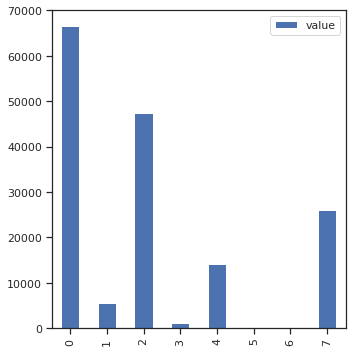

In [37]:
BSS_ap.plot.bar(y='value',figsize = (5,5))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

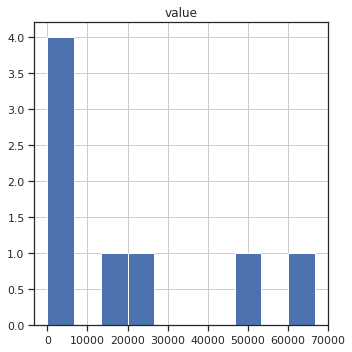

In [38]:
BSS_ap.hist(figsize = (5,5))
plt.show

In [39]:
#carré du rapport de corrélation
#variance expliquée par l'appartenance aux groupes
#pour chaque variable

R2 = BSS/TSS
R2 = R2.reset_index(name ='value')
R2

index     value
0              energy_100g  0.966541
1                 fat_100g  0.560368
2       saturated-fat_100g  0.398096
3              sugars_100g  0.298222
4               fiber_100g  0.267845
5            proteins_100g  0.349958
6                salt_100g  0.206825
7              sodium_100g  0.206827
8  nutrition-score-fr_100g  0.437529

<function matplotlib.pyplot.show(close=None, block=None)>

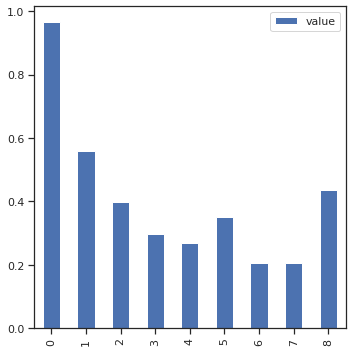

In [40]:
R2.plot.bar(y = 'value' ,figsize = (5,5))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

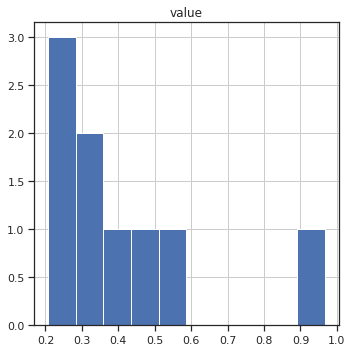

In [41]:
R2.hist(figsize = (5,5))
plt.show

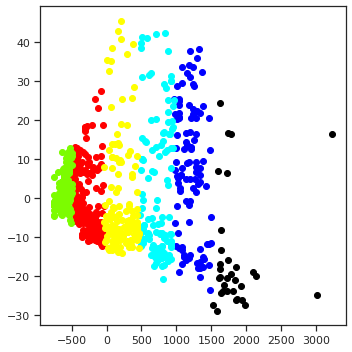

In [42]:
acp = PCA(n_components=3).fit_transform(sample)

# projeter dans le plan factoriel
# avec un code couleur différent selon le groupe


fig = plt.figure(figsize=(5,5))
for couleur,k in zip(['red','blue','lawngreen','aqua','black','yellow','brown'],
                     [0,1,2,3,4,5,6]):    
    plt.scatter(acp[kmeans.labels_==k,0],acp[kmeans.labels_==k,1],c=couleur)

plt.show()

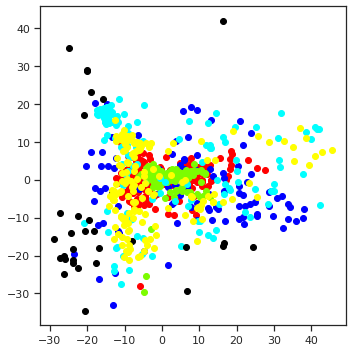

In [43]:
fig = plt.figure(figsize=(5,5))
for couleur,k in zip(['red','blue','lawngreen','aqua','black','yellow','brown'],[0,1,2,3,4,5,6]):    
    plt.scatter(acp[kmeans.labels_==k,1],acp[kmeans.labels_==k,2],c=couleur)

## Conclusion

### En résumé, l'application Equilibre fournira des analyses, des conseils et des recommandations à l'utilisateur tout en respectant ses contraintes et en évitant d'imposer des contraintes supplémentaires. Si l'utilisateur ne souhaite pas faire du sport, l'application suggérera de marcher un peu plus lorsqu'il se déplace à la poste, et en ce qui concerne les produits, elle proposera des alternatives ou adaptera les courbes nutritionnelles en fonction des produits disponibles et ajustera les quantités en conséquence.